In [25]:
import fsspec
import zarr
import xarray as xr
import random
import matplotlib.pyplot as plt
import numpy as np

# Demo access with xarray and Dask

This section aims at showing how much time is needed to randomly access data from a remote data cube in a non optimal way.

We open a connection to a remote data cube (UC3 sub cube for time series analysis) and access its five variables: avg_rh ignition_points time burned_areas lst_day x evi y

In [7]:
m = fsspec.get_mapper("https://storage.de.cloud.ovh.net/v1/AUTH_84d6da8e37fe4bb5aea18902da8c1170/uc3/UC3SubCube_ts.zarr")
g = xr.open_zarr(m)
g

,Array,Chunk
Bytes,20.92 GiB,781.25 kiB
Shape,"(4560, 983, 1253)","(500, 20, 20)"
Count,31501 Tasks,31500 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.92 GiB,781.25 kiB
Shape,"(4560, 983, 1253)","(500, 20, 20)"
Count,31501 Tasks,31500 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


We then randomly sample 20 locations in the cube over a fixed time range

In [60]:
randlat = list(map(lambda x: random.randrange(g.dims['y']),range(20)))
randlon = list(map(lambda x: random.randrange(g.dims['x']),range(20)))
print(randlat)
print(randlon)

[936, 791, 621, 572, 832, 331, 584, 839, 588, 616, 971, 751, 59, 582, 974, 364, 113, 861, 558, 239]
[155, 1160, 347, 653, 119, 526, 1028, 1157, 110, 255, 129, 533, 334, 83, 798, 1252, 317, 611, 123, 999]


In [61]:
selection = g.isel(x=randlon, y=randlat).loc[dict(time=slice("2001-01-01", "2016-12-31"))]

In [62]:
selection

,Array,Chunk
Bytes,4.36 MiB,1.95 kiB
Shape,"(2858, 20, 20)","(500, 1, 1)"
Count,47901 Tasks,2400 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.36 MiB,1.95 kiB
Shape,"(2858, 20, 20)","(500, 1, 1)"
Count,47901 Tasks,2400 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


We use this selection to plot evi.

Text(0.5, 1.0, 'data accessed with xarray')

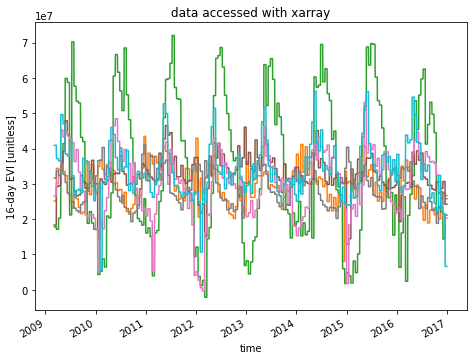

In [64]:
fill_value = 1e32
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
for i in range(selection.dims['y']):
    y = selection.evi.isel(x=i, y=i)
    y.plot.line(ax=ax)

ax.set_title("data accessed with xarray")

# Demo with batch shuffler


In [65]:
# m = fsspec.get_mapper("http://macadamia.bgc-jena.mpg.de:9052")
m = fsspec.get_mapper("http://127.0.0.1:9052")
g = zarr.open_consolidated(m)

In [66]:
batches = g["batches"]

In [67]:
batches.shape

(100, 5, 2858)

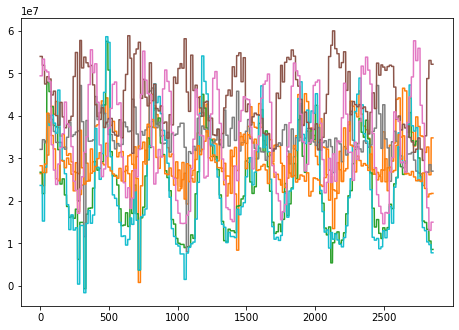

In [71]:
fill_value = 1e32

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
for i in range(20):
    y = batches[i,4,:]
    ax.plot(np.ma.masked_where(y == fill_value, y))